In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib.calc as c
import scipy.ndimage as nd
from skimage import filters, exposure, restoration, morphology, feature, measure
from ipywidgets import interact
from silx.io import specfile as spec
from matplotlib import patches

%matplotlib inline
%cd wshed

/users/zatterin/Documents/beam/hc3211/ipynb/img_analysis/wshed


Definition of a function that takes and image and a fraction, outputs thresholded image and corresponding masked array.

In [265]:
def thresholdit(img,n):
    # select an image
    kmap = img
    se = morphology.selem.disk(1)

    # compute rmax
    h = kmap.max() - kmap.max()/20
    hmax = morphology.reconstruction(kmap-h, kmap, method='dilation', 
                                     selem=morphology.selem.disk(1))
    rmax = kmap - hmax

    # close gaps in rmax
    rmax_closed = morphology.closing(rmax, selem=morphology.selem.disk(1))

    # totally arbitrary threshold!!
    ots = filters.threshold_li(rmax_closed)
    rmax_ts = rmax_closed > n*rmax_closed.max()
    rmax_tsm = morphology.binary_dilation(rmax_ts, selem=se) ^ morphology.binary_erosion(rmax_ts, selem=se)

    # mask it
    mask = np.ma.masked_where(rmax_tsm==0, rmax_tsm)
    
    return rmax_ts, mask

### Load data
Shifted and noise corrected rois for A1 kmap. Watershed lines as well.

In [237]:
# load rois vs voltage of A1
roi1 = np.load('roi1_shifted.npy')
roi2 = np.load('roi2_shifted.npy')
roi3 = np.load('roi3_shifted.npy')
roi4 = np.load('roi4_shifted.npy')

# watersheds of the first image of each roi
wshed1 = np.load('wshed_line_roi1.npy')
wshed2 = np.load('wshed_line_roi2.npy')
wshed3 = np.load('wshed_line_roi3.npy')
wshed4 = np.load('wshed_line_roi4.npy')

# the voltages
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70]#,100,150]

In [238]:
# mask the wsheds
wshed1 = np.ma.masked_where(wshed1!=0, wshed1)
wshed2 = np.ma.masked_where(wshed2!=0, wshed2)
wshed3 = np.ma.masked_where(wshed3!=0, wshed3)
wshed4 = np.ma.masked_where(wshed4!=0, wshed4)

### Visualisation
Choose a roi and take a look at the segmented data.

In [296]:
roiA = roi2
roiB = roi4

In [297]:
# roiA/ roiB
@interact(i=(0, len(roi)-1))
def plot(i=0):
    fig, axes = plt.subplots(2,3,figsize=(15,8),)
    ax = axes.ravel()
    for a in ax: a.axis('off')

    ax[0].imshow(roiA[0])
    ax[0].imshow(wshedA,cmap='Reds',alpha=0.5)
    ax[0].set_title(r'$a_1$ segmented @ 5V')

    ax[1].imshow(roiA[i])
    ax[1].imshow(wshedA,cmap='Reds',alpha=0.5)
    ax[1].set_title(r'$a_1$ - {0} V'.format(voltages[i]))
    
    ax[2].imshow(roiA[i])
    ax[2].imshow(wshedB,cmap='Reds',alpha=0.5)
    ax[2].set_title(r'$a_1$ - {0} V ($a_2$ lines)'.format(voltages[i]))
    
    ax[3].imshow(roiB[0])
    ax[3].imshow(wshedB,cmap='Reds',alpha=0.5)
    ax[3].set_title(r'$a_2$ segmented @ 5V')

    ax[4].imshow(roiB[i])
    ax[4].imshow(wshedB,cmap='Reds',alpha=0.5)
    ax[4].set_title(r'$a_2$ - {0} V'.format(voltages[i]))

    ax[5].imshow(roiB[i])
    ax[5].imshow(wshedA,cmap='Reds',alpha=0.5)
    ax[5].set_title(r'$a_2$ - {0} V ($a_1$ lines)'.format(voltages[i]))

    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',))

#### TODO:
* ~~segment with threshold only - drawr "threshold lines" similar to the above. Still better than the watershed for visualisation I think.~~
* ~~segment separately the positive and negative voltages.~~

## Global thresholding
To calculate switching pixels as a function of voltage.

### Mask 0-70V

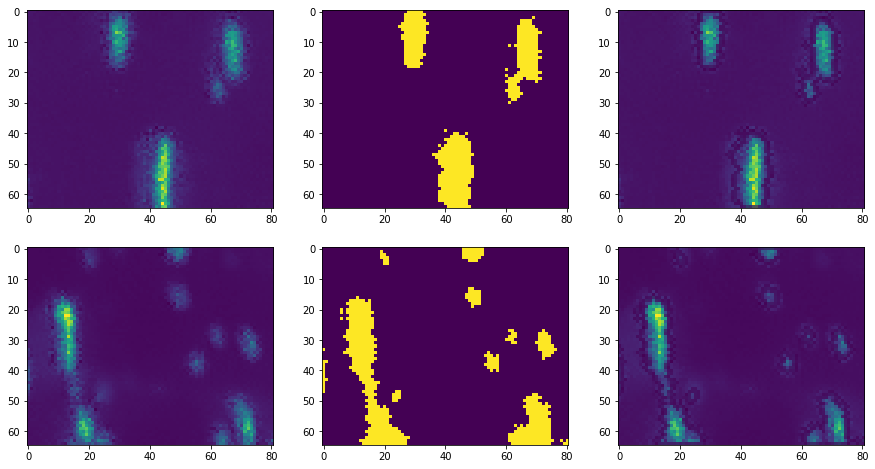

In [298]:
imgA = roiA[0] # 0V
imgB = roiB[0]

tA_0v, maskA_0v = thresholdit(imgA,0.15)
tB_0v, maskB_0v = thresholdit(imgB,0.15)

# plot
fig, axes = plt.subplots(2,3, figsize=(15,8))
ax = axes.ravel()

ax[0].imshow(imgA)
ax[1].imshow(tA_0v)
ax[2].imshow(imgA)
ax[2].imshow(maskA_0v, alpha=0.6)

ax[3].imshow(imgB)
ax[4].imshow(tB_0v)
ax[5].imshow(imgB)
ax[5].imshow(maskB, alpha=0.6);

In [245]:
maskA_0v = np.ma.masked_where(maskA==0, maskA)
maskB_0v = np.ma.masked_where(maskB==0, maskB)

Up to +70V:

In [295]:
# roiA/ roiB
@interact(i=(0, 7))
def plot(i=0):
    fig, axes = plt.subplots(2,3,figsize=(15,8),)
    ax = axes.ravel()
    for a in ax: a.axis('off')

    ax[0].imshow(roiA[0])
    ax[0].imshow(maskA_0v,cmap='Reds',alpha=0.5)
    ax[0].set_title(r'$a_1$ segmented @ 5V')

    ax[1].imshow(roiA[i])
    ax[1].imshow(maskA_0v,cmap='Reds',alpha=0.5)
    ax[1].set_title(r'$a_1$ - {0} V'.format(voltages[i]))
    
    ax[2].imshow(roiA[i])
    ax[2].imshow(maskB_0v,cmap='Reds',alpha=0.5)
    ax[2].set_title(r'$a_1$ - {0} V ($a_2$ lines)'.format(voltages[i]))
    
    ax[3].imshow(roiB[0])
    ax[3].imshow(maskB_0v,cmap='Reds',alpha=0.5)
    ax[3].set_title(r'$a_2$ segmented @ 5V')

    ax[4].imshow(roiB[i])
    ax[4].imshow(maskB_0v,cmap='Reds',alpha=0.5)
    ax[4].set_title(r'$a_2$ - {0} V'.format(voltages[i]))

    ax[5].imshow(roiB[i])
    ax[5].imshow(maskA_0v,cmap='Reds',alpha=0.5)
    ax[5].set_title(r'$a_2$ - {0} V ($a_1$ lines)'.format(voltages[i]))

    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',))

### Mask 70 - -70V

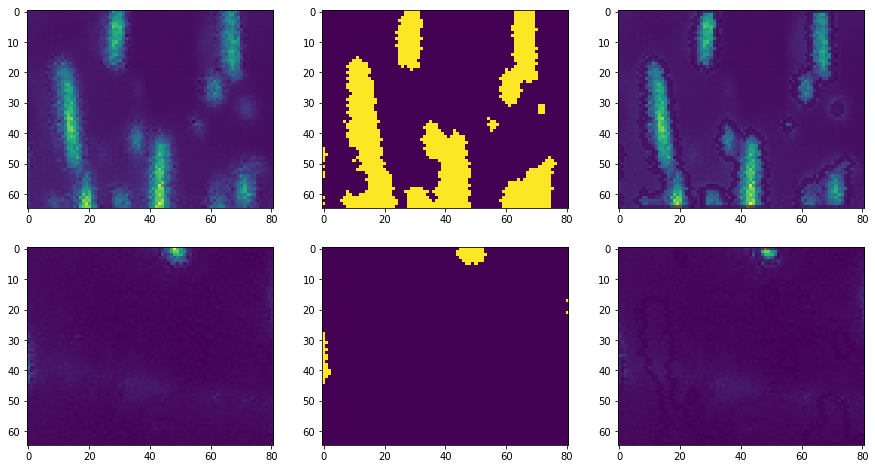

In [267]:
imgA = roiA[7] # 70V
imgB = roiB[7]

tA_70v, maskA_70v = thresholdit(imgA,0.15)
tB_70v, maskB_70v = thresholdit(imgB,0.2)

# plot
fig, axes = plt.subplots(2,3, figsize=(15,8))
ax = axes.ravel()

ax[0].imshow(imgA)
ax[1].imshow(tA_70v)
ax[2].imshow(imgA)
ax[2].imshow(maskA_70v, alpha=0.6)

ax[3].imshow(imgB)
ax[4].imshow(tB_70v)
ax[5].imshow(imgB)
ax[5].imshow(maskB, alpha=0.6);

from +70V to -70V

In [269]:
# roiA/ roiB
@interact(i=(7, len(roi)-1))
def plot(i=0):
    fig, axes = plt.subplots(2,3,figsize=(15,8),)
    ax = axes.ravel()
    for a in ax: a.axis('off')

    ax[0].imshow(roiA[7])
    ax[0].imshow(maskA_70v,cmap='Reds',alpha=0.5)
    ax[0].set_title(r'$a_1$ segmented @ 70V')

    ax[1].imshow(roiA[i])
    ax[1].imshow(maskA_70v,cmap='Reds',alpha=0.5)
    ax[1].set_title(r'$a_1$ - {0} V'.format(voltages[i]))
    
    ax[2].imshow(roiA[i])
    ax[2].imshow(maskB_70v,cmap='Reds',alpha=0.5)
    ax[2].set_title(r'$a_1$ - {0} V ($a_2$ lines)'.format(voltages[i]))
    
    ax[3].imshow(roiB[7])
    ax[3].imshow(maskB_70v,cmap='Reds',alpha=0.5)
    ax[3].set_title(r'$a_2$ segmented @ 70V')

    ax[4].imshow(roiB[i])
    ax[4].imshow(maskB_70v,cmap='Reds',alpha=0.5)
    ax[4].set_title(r'$a_2$ - {0} V'.format(voltages[i]))

    ax[5].imshow(roiB[i])
    ax[5].imshow(maskA_70v,cmap='Reds',alpha=0.5)
    ax[5].set_title(r'$a_2$ - {0} V ($a_1$ lines)'.format(voltages[i]))

    plt.show()

interactive(children=(IntSlider(value=7, description='i', max=14, min=7), Output()), _dom_classes=('widget-interact',))

**TODO**
* repeat the above for roiB (and 2 and 4, of course)
* use these thresholds to calc domain fractions (0->70 different from 70->-70)
* do it for A2 as well. (save stuff while you go, of course)

## Calc domain fractions

In [289]:
# up to 70v
thresholds_0 = []
for index in range(8):
    t, mask = thresholdit(roiA[index],0.15)
    thresholds_0.append(t)
    
# visualise how stuff below mask changes with V
@interact(i=(0,7,1))
def p(i=0):
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    fig.suptitle(str(voltages[i])+' V')
    ax[0].imshow(roiA[i])
    ax[0].imshow(thresholds_0[i], alpha=0.3)
    ax[1].imshow(thresholds_0[i] ^thresholds_0[0])
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',))

In [290]:
# up to -70v
thresholds_70 = []
for index in range(7,15):
    t, mask = thresholdit(roiA[index],0.15)
    thresholds_70.append(t)
    
# visualise how stuff below mask changes with V
@interact(i=(0,7,1))
def p(i=0):
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    fig.suptitle(str(voltages[i+7])+' V')
    ax[0].imshow(roiA[i+7])
    ax[0].imshow(thresholds_70[i], alpha=0.3)
    ax[1].imshow(thresholds_70[i] ^ thresholds_70[0])
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',))

In [291]:
upv, downv = [], []
for i in range(len(thresholds_0)):
    upv.append(np.count_nonzero(thresholds_0[i] ^ thresholds_0[0]))
for i in range(len(thresholds_70)):
    downv.append(np.count_nonzero(thresholds_70[i] ^ thresholds_70[0]))

In [53]:
norm0 = thresholds_0[0].size - np.count_nonzero(thresholds_0[0]) # n of zero pixels
norm70 = thresholds_70[0].size - np.count_nonzero(thresholds_70[0])

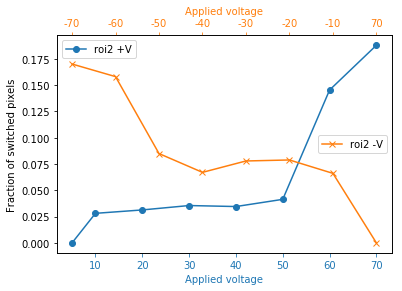

In [294]:
fig, ax1 = plt.subplots()

ax1.plot(voltages[:8],[x/thresholds_0[0].size for x in upv], c='C0', marker='o', label='roi2 +V')
ax1.set_xlabel('Applied voltage',color='C0')
ax1.set_ylabel('Fraction of switched pixels')
ax1.tick_params('x', colors='C0')
ax1.legend(loc=0)

ax2 = ax1.twiny()
ax2.plot(range(7,-1,-1),[x/thresholds_70[0].size for x in downv], c='C1', marker='x', label='roi2 -V')
# plt.plot(range(7,-1,-1),[(-x/norm70)+(upv[7]/norm0) for x in downv], c='C1', marker='x', label='-V')
# plt.plot(range(7,-1,-1),[-x/thresholds_70[0].size+(upv[7]/thresholds_70[7].size) for x in downv], c='C1', marker='x', label='-V')
ax2.set_xticklabels([-70,-70,-60,-50,-40,-30,-20,-10,70]) # wtf??
ax2.set_xlabel('Applied voltage',color='C1')
ax2.tick_params('x', colors='C1')
ax2.legend(loc=5)

plt.show()